In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

from qiskit.visualization import plot_histogram

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [3]:
check_qubits = QuantumRegister(2, name='c')
var_qubits = QuantumRegister(2, name='v')
sum_qubits = QuantumRegister(2, name='s')
clause_qubits = QuantumRegister(2, name='cl')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(2, name='cbits')

qc = QuantumCircuit(check_qubits, var_qubits, sum_qubits, clause_qubits, output_qubit, cbits)

In [4]:
def oracle(qc):
    qc.cx(var_qubits[0], sum_qubits[0])
    qc.cx(var_qubits[1], sum_qubits[0])
    qc.mct(var_qubits, sum_qubits[1])
    qc.cx(check_qubits[0], clause_qubits[0])
    qc.cx(sum_qubits[1], clause_qubits[0])
    qc.cx(check_qubits[1], clause_qubits[1])
    qc.cx(sum_qubits[0], clause_qubits[1])
    
    qc.mct(clause_qubits, output_qubit)
    
    qc.barrier()
    
    qc.cx(var_qubits[0], sum_qubits[0])
    qc.cx(var_qubits[1], sum_qubits[0])
    qc.mct(var_qubits, sum_qubits[1])
    qc.cx(check_qubits[0], clause_qubits[0])
    qc.cx(sum_qubits[1], clause_qubits[0])
    qc.cx(check_qubits[1], clause_qubits[1])
    qc.cx(sum_qubits[0], clause_qubits[1])
    
# oracle(qc)
# qc.draw()

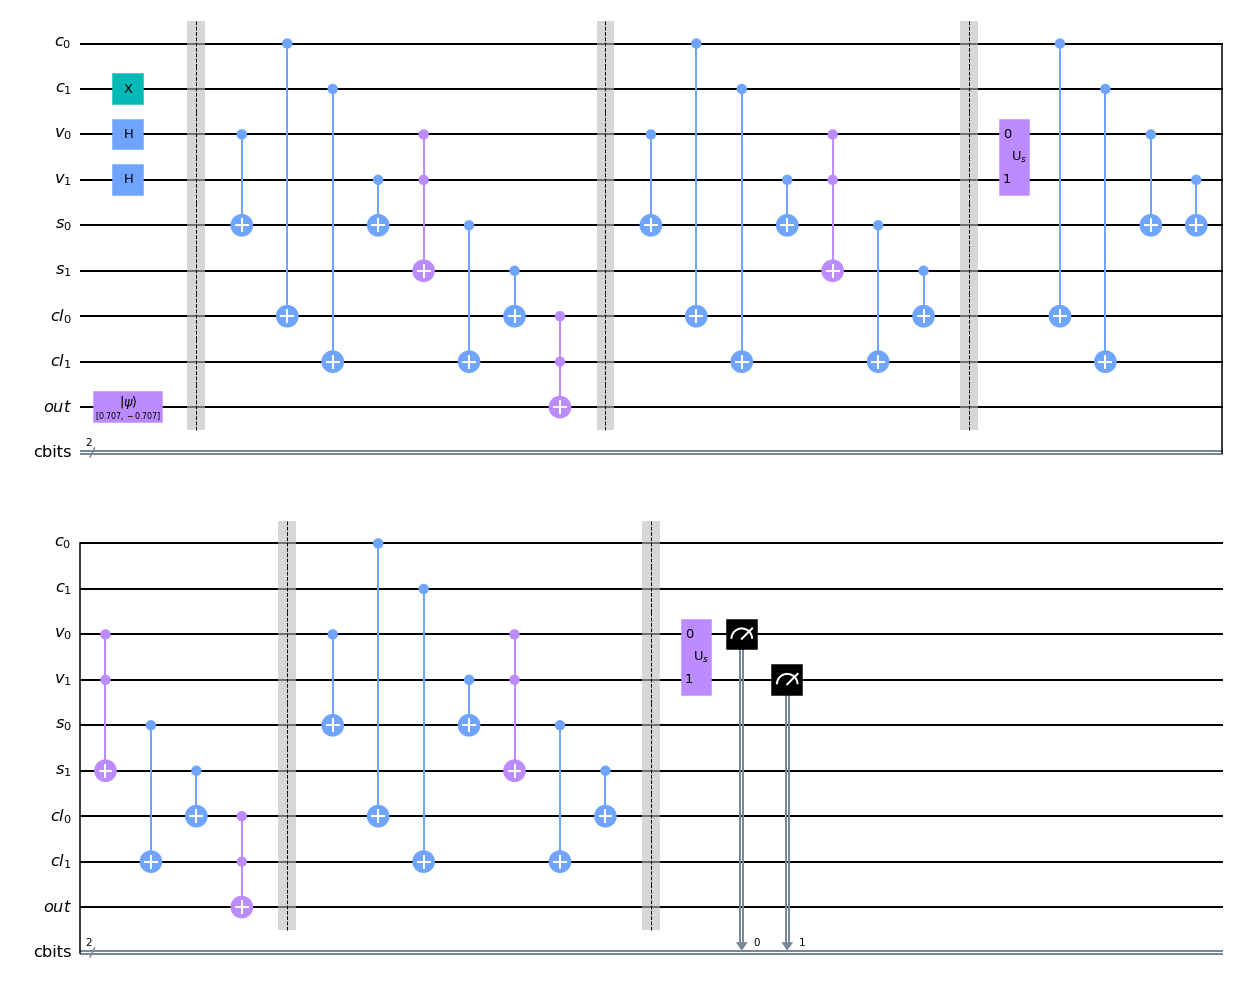

In [5]:
check_qubits = QuantumRegister(2, name='c')
var_qubits = QuantumRegister(2, name='v')
sum_qubits = QuantumRegister(2, name='s')
clause_qubits = QuantumRegister(2, name='cl')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(2, name='cbits')

qc = QuantumCircuit(check_qubits, var_qubits, sum_qubits, clause_qubits, output_qubit, cbits)

# initialize the output_qubit in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

qc.x(1)

# initialize the qubits in state |s>
qc.h(var_qubits)
qc.barrier()

# apply the oracle n times (### RESULTS NOT CONSISTENT WITH DIFFERENT Ns
n = 2
for i in range(n):
    oracle(qc)
    qc.barrier()
    qc.append(diffuser(2), [2, 3])

# measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw()

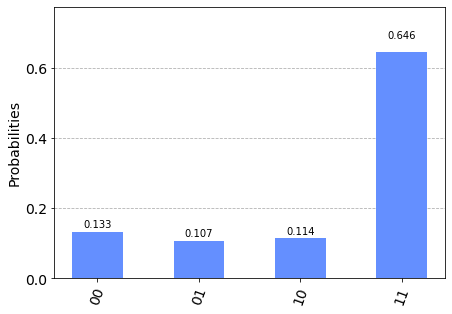

In [6]:
# simulate and plot results
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_simulator.run(qobj).result()
plot_histogram(result.get_counts())